In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from transformers import ViTModel

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT needs minimum 224x224
    transforms.ToTensor(),
])
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Modified ViT Model Definition
class ViTEmbedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        # Convert grayscale to 3 channels
        self.channel_adapter = nn.Conv2d(1, 3, kernel_size=1)  # Better than repeating channels
        self.classifier = nn.Linear(768, 10)  # MNIST has 10 classes

    def forward(self, x):
        # Convert 1-channel to 3-channel
        x = self.channel_adapter(x)  # [B, 3, 224, 224]
        outputs = self.vit(x)
        embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        return self.classifier(embeddings), embeddings

# Initialize model
model = ViTEmbedder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(5):
    model.train()
    total_loss = 0
    
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        logits, embeddings = model(imgs)
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 26.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 790kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 8.16MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1, Loss: 0.1968
Epoch 2, Loss: 0.0353
Epoch 3, Loss: 0.0234
Epoch 4, Loss: 0.0150
Epoch 5, Loss: 0.0138


In [2]:
# Collect embeddings
all_embeddings = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        _, embeddings = model(imgs)
        all_embeddings.append(embeddings.cpu())
        all_labels.append(labels)

embeddings = torch.cat(all_embeddings).numpy()
labels = torch.cat(all_labels).numpy()

/home/ubuntu/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


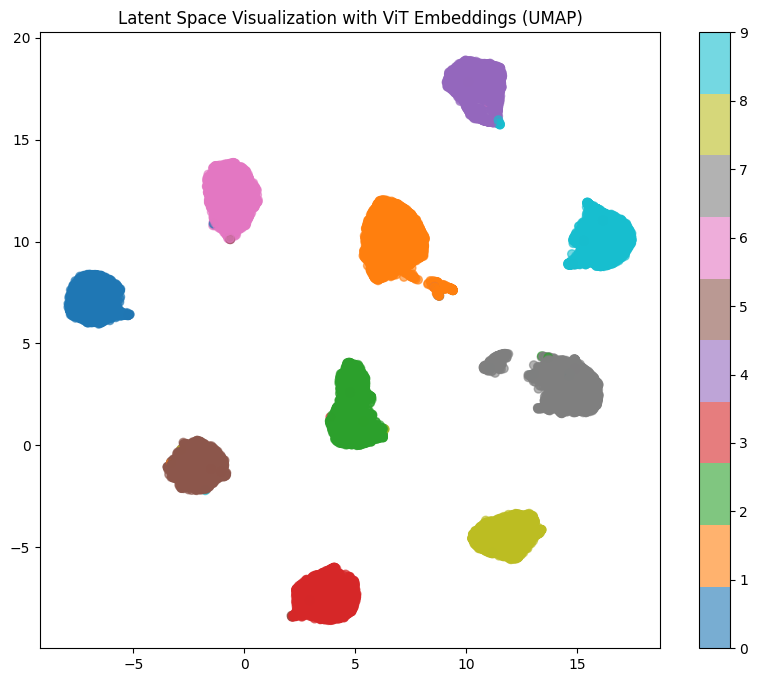

In [5]:
# UMAP projection (same as before)
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP()
emb_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='tab10', alpha=0.6)
plt.title('Latent Space Visualization with ViT Embeddings (UMAP)')
plt.colorbar()
plt.show()

In [13]:
import os
model_save_path = "./models/vit-mnist"

In [14]:
def save_model(model: ViTEmbedder):
    os.makedirs(model_save_path, exist_ok=True)
    model.vit.save_pretrained(model_save_path)
    torch.save({
        'channel_adapter': model.channel_adapter.state_dict(),
        'classifier': model.classifier.state_dict()
    }, os.path.join(model_save_path, "custom_layers.pth"))

In [15]:
def load_model() -> ViTEmbedder:
    vit = ViTModel.from_pretrained(model_save_path)
    model = ViTEmbedder()
    model.vit = vit
    custom_layers = torch.load(os.path.join(save_path, "custom_layers.pth"))
    model.channel_adapter.load_state_dict(custom_layers['channel_adapter'])
    model.classifier.load_state_dict(custom_layers['classifier'])
    model.eval()
    return model

In [16]:
# Only run this on the cloud instance after finetuning the model
if False:
    save_model(model)